<a href="https://colab.research.google.com/github/mehrnazeraeisi/Advertising/blob/main/Advertising_KnnRegression_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split


In [2]:

# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        r2 = knn_reg.score(X_feature, y)
        features_scores.append((feature, r2))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score']).sort_values(by='R2_Score', ascending=False)
    return df_scores


In [4]:
# بارگذاری فایل اکسل
data = pd.read_csv('advertising.csv')

print(data.columns)
data.shape

# نمایش اطلاعات
print(data.head())



# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('sales', axis=1)  # همه ستون‌ها به جز 'target'
y_data = data['sales']              # فقط ستون 'target'
data_features = X_data.columns       # نام ویژگی‌ها


Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')
      TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9


In [5]:
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (Diabetes dataset):")
print(data_scores)  # Categorize features by R² score

🔎 Feature Group Performance Summary (Diabetes dataset):
     Feature  R2_Score
0         TV  0.663212
1      radio  0.491364
2  newspaper  0.209107


In [6]:
# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.8]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > 0.7)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['R2_Score'] > 0.6)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['R2_Score'] > 0.5)]['Feature'].tolist()
medium_features_4 = data_scores[(data_scores['R2_Score'] > 0.4)]['Feature'].tolist()
medium_features_5 = data_scores[(data_scores['R2_Score'] > 0.3)]['Feature'].tolist()
medium_features_6 = data_scores[(data_scores['R2_Score'] > 0.2)]['Feature'].tolist()
poor_features = data_scores[data_scores['R2_Score'] <= 0.2]['Feature'].tolist()


In [7]:
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)

In [8]:

# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1, medium_features_2, medium_features_3,
          medium_features_4, medium_features_5, medium_features_6, poor_features]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]


In [9]:
# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['Data Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)', 'Medium Features_2 (0.6-0.7)',
                      'Medium Features_3 (0.5-0.6)', 'Medium Features_4 (0.4-0.5)', 'Medium Features_5 (0.3-0.4)',
                      'Medium Features_6 (0.2-0.3)', 'Poor Features'],
    'R2_Score': r2_scores
})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)


📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score
0                 All Features  0.952944
1              Strong Features       NaN
2  Medium Features_1 (0.7-0.8)       NaN
3  Medium Features_2 (0.6-0.7)  0.663212
4  Medium Features_3 (0.5-0.6)  0.663212
5  Medium Features_4 (0.4-0.5)  0.976655
6  Medium Features_5 (0.3-0.4)  0.976655
7  Medium Features_6 (0.2-0.3)  0.952944
8                Poor Features       NaN


In [10]:

def knn_evaluation(X_data, y_data,medium_features_4, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    r2_scores = {
        "Data_features": [],
        "medium_features_4": [],

    }


    # List of feature groups to evaluate
    feature_groups = {
        "Data_features": data_features,
        "medium_features_4": medium_features_4,

    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 4))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()



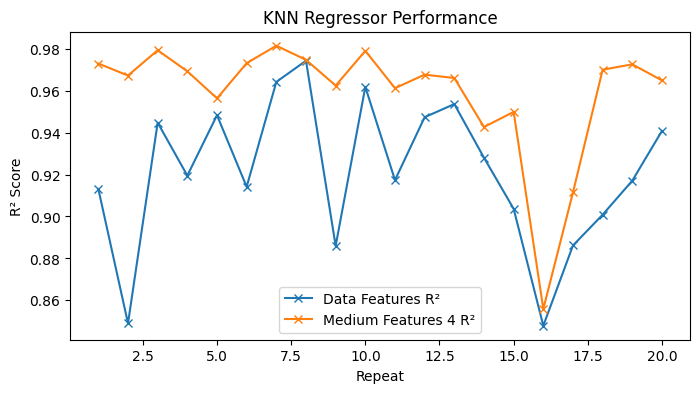

In [11]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_4,  data_features, test_size=0.1, n_repeats=20)


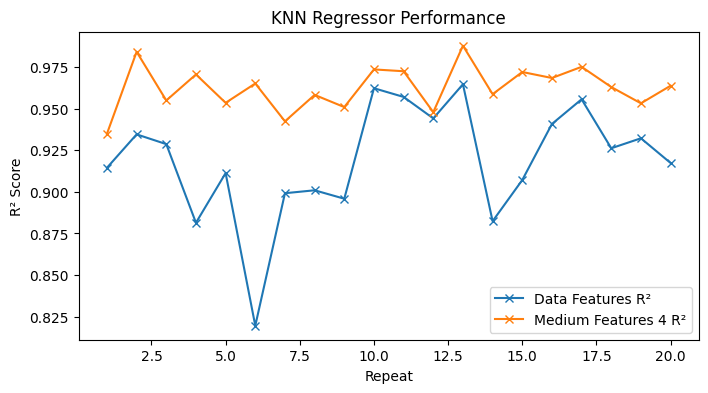

In [12]:
# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_4,  data_features, test_size=0.13, n_repeats=20)


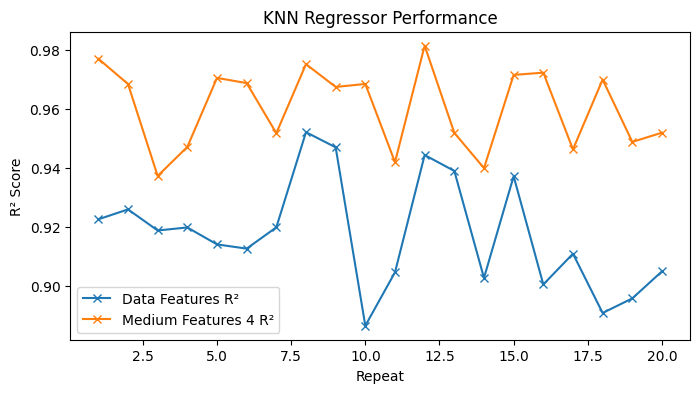

In [13]:
# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_4, data_features, test_size=0.16, n_repeats=20)


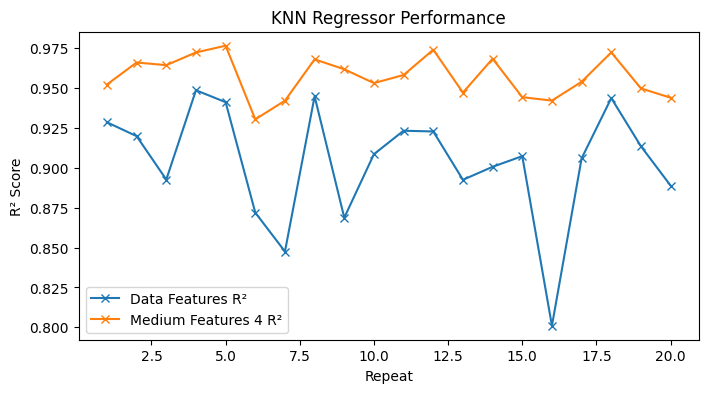

In [14]:
# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, medium_features_4, data_features, test_size=0.19, n_repeats=20)


Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')
      TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9
🔎 Feature Group Performance Summary (Cancer dataset):
     Feature  R2_Score
0         TV  0.663212
1      radio  0.491364
2  newspaper  0.209107

📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score
0                 All Features  0.952944
1              Strong Features       NaN
2  Medium Features_1 (0.7-0.8)       NaN
3  Medium Features_2 (0.6-0.7)  0.663212
4  Medium Features_3 (0.5-0.6)  0.663212
5  Medium Features_4 (0.4-0.5)  0.976655
6  Medium Features_5 (0.3-0.4)  0.976655
7  Medium Features_6 (0.2-0.3)  0.952944
8                Poor Features       NaN


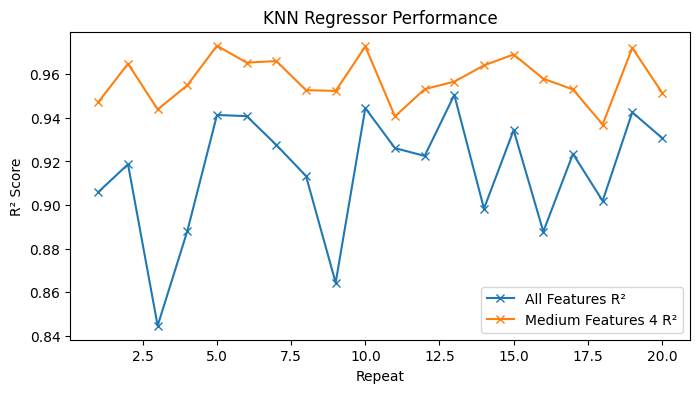

In [15]:
#[1]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



#[2]
# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        r2 = knn_reg.score(X_feature, y)
        features_scores.append((feature, r2))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score']).sort_values(by='R2_Score', ascending=False)
    return df_scores




# بارگذاری فایل اکسل
data = pd.read_csv('advertising.csv')

print(data.columns)
data.shape

# نمایش اطلاعات
print(data.head())



# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('sales', axis=1)  # همه ستون‌ها به جز 'target'
y_data = data['sales']              # فقط ستون 'target'
data_features = X_data.columns       # نام ویژگی‌ها


#[5]
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (Cancer dataset):")
print(data_scores)  # Categorize features by R² score


# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.8]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > 0.7)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['R2_Score'] > 0.6)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['R2_Score'] > 0.5)]['Feature'].tolist()
medium_features_4 = data_scores[(data_scores['R2_Score'] > 0.4)]['Feature'].tolist()
medium_features_5 = data_scores[(data_scores['R2_Score'] > 0.3)]['Feature'].tolist()
medium_features_6 = data_scores[(data_scores['R2_Score'] > 0.2)]['Feature'].tolist()
poor_features = data_scores[data_scores['R2_Score'] <= 0.2]['Feature'].tolist()

#[7]
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)






#[8]
# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1, medium_features_2, medium_features_3,
          medium_features_4, medium_features_5, medium_features_6, poor_features ]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]


# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['All Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)', 'Medium Features_2 (0.6-0.7)',
                      'Medium Features_3 (0.5-0.6)', 'Medium Features_4 (0.4-0.5)', 'Medium Features_5 (0.3-0.4)',
                      'Medium Features_6 (0.2-0.3)', 'Poor Features'],
    'R2_Score': r2_scores
})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)




def knn_evaluation(X_data, y_data, medium_features_4, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    r2_scores = {
        "all_features": [],
        "medium_features_4": [],
    }

    # List of feature groups to evaluate
    feature_groups = {
        "all_features": data_features,
        "medium_features_4": medium_features_4,
    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 4))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()



# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data,  medium_features_4, data_features, test_size=0.19, n_repeats=20)
